In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df=pd.read_csv('../Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [11]:
df.columns=['Sales']

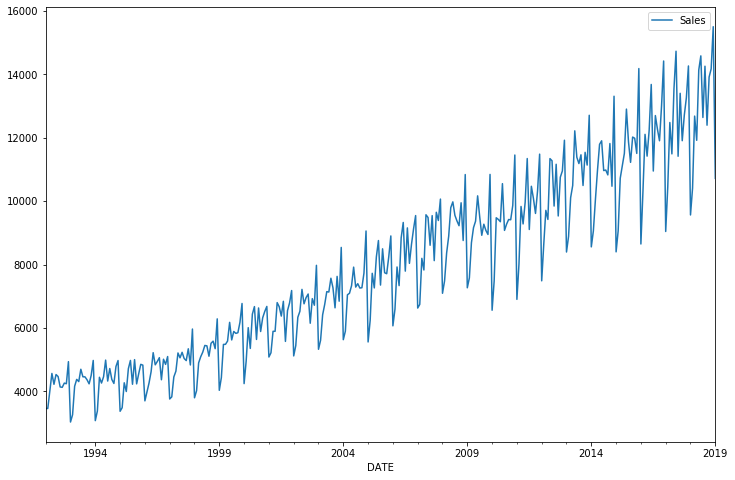

In [5]:
df.plot(figsize=(12,8)) #some trend and seasonality

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
res=seasonal_decompose(df['Sales'])

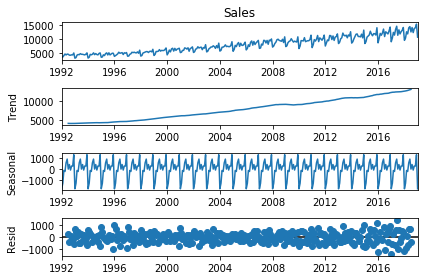

In [9]:
res.plot();

In [12]:
train=df.iloc[:313]
test=df.iloc[313:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler=MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train=scaler.transform(train)
scled_test=scaler.transform(test)

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
scaled_train

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ],
       [0.0196598 ],
       [0.09650397],
       [0.11505257],
       [0.10906915],
       [0.14231986],
       [0.12197624],
       [0.12189076],
       [0.11394136],
       [0.10300026],
       [0.12556629],
       [0.16608257],
       [0.00376101],
       [0.02957518],
       [0.12069408],
       [0.10513719],
       [0.12214719],
       [0.16702282],
       [0.11052227],
       [0.14428584],
       [0.11479614],
       [0.10402599],
       [0.14984187],
       [0.16582614],
       [0.02897684],
       [0.03872126],
       [0.10582101],
       [0.08231473],
       [0.14394393],
       [0.16608257],
       [0.10188905],
       [0.16830498],
       [0.10291478],
       [0.13018207],
       [0.15556885],
       [0.153

In [27]:
n_input=3
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [28]:
len(scaled_train)

313

In [29]:
len(generator)

310

In [30]:
X,y=generator[0]

In [31]:
X

array([[[0.03658432],
        [0.03649885],
        [0.08299855]]])

In [32]:
y

array([[0.13103684]])

In [26]:
scaled_train[:5] #so what it is happening is that based on n_input it takes the first n input parameter and trying to produce the next input as predicted value

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [33]:
#how to select the input value so if seasonality is there we need to give atleast 12

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [39]:
n_input=12
n_features=1
train_generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [40]:
model=Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit_generator(train_generator,epochs=25)

Epoch 1/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0125
Epoch 2/25
301/301 [==============================] - 2s 6ms/step - loss: 0.0101
Epoch 3/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0085
Epoch 4/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0062
Epoch 5/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0053
Epoch 6/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0032
Epoch 7/25
301/301 [==============================] - 2s 6ms/step - loss: 0.0030
Epoch 8/25
301/301 [==============================] - 2s 6ms/step - loss: 0.0027
Epoch 9/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 10/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 11/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0023
Epoch 12/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 13/25
301/301 [====

In [44]:
myloss=model.history.history['loss']

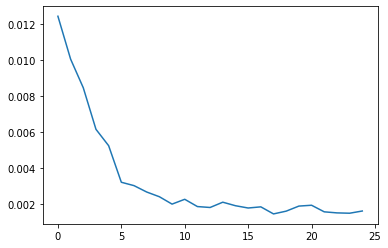

In [45]:
plt.plot(range(len(myloss)),myloss)

In [46]:
#12 history steps --- 13 step
#last 12 train point --pt 1 of test data

In [47]:
first_eval_batch=scaled_train[-12:]

In [49]:
first_eval_batch=first_eval_batch.reshape((1,n_input,n_features))

In [50]:
model.predict(first_eval_batch)

array([[0.72794485]], dtype=float32)

# Forecast using RNN

In [51]:
test_pred=[] #holding my predictions
#last n inputs from the training dataset
first_eval_batch=scaled_train[-n_input:]
#reshaping this to the format RNN wants (same format as TimeseriesGenerator)
curren_batch=first_eval_batch.reshape((1,n_input,n_features))


#how far into  the future will i forcast
#len(test)
for i in range (len(test)):
    #one timestep ahead of historical 12 points
    curren_pred=model.predict(curren_batch)[0]
    #store that predictions
    test_pred.append(curren_pred)
    #update current batch to include predictions
    curren_batch=np.append(curren_batch[:,1:,:],[[curren_pred]],axis=1)

In [52]:
test_pred

[array([0.72794485], dtype=float32),
 array([0.8534685], dtype=float32),
 array([0.808272], dtype=float32),
 array([0.97055465], dtype=float32),
 array([1.0512363], dtype=float32),
 array([0.79437095], dtype=float32),
 array([0.9471968], dtype=float32),
 array([0.8090532], dtype=float32),
 array([0.8904338], dtype=float32),
 array([0.9343613], dtype=float32),
 array([1.0148379], dtype=float32),
 array([0.6356116], dtype=float32)]

In [53]:
true_pred=scaler.inverse_transform(test_pred)

In [54]:
true_pred

array([[11547.22681093],
       [13015.72772092],
       [12486.97417629],
       [14385.51884836],
       [15329.41314447],
       [12324.34573549],
       [14112.25514835],
       [12496.11318326],
       [13448.18488932],
       [13962.09260315],
       [14903.58813655],
       [10467.02003497]])

In [55]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [56]:
test['pred']=true_pred

C:\Users\Jasar Althaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
test

,Sales,pred
DATE,,
2018-02-01,10415,11547.226811
2018-03-01,12683,13015.727721
2018-04-01,11919,12486.974176
2018-05-01,14138,14385.518848
2018-06-01,14583,15329.413144
2018-07-01,12640,12324.345735
2018-08-01,14257,14112.255148
2018-09-01,12396,12496.113183
2018-10-01,13914,13448.184889


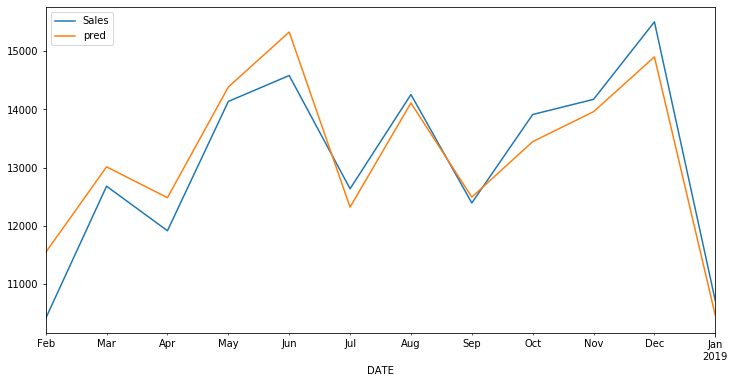

In [58]:
test.plot(figsize=(12,6))

In [59]:
model.save('mycoolmodel.h5')

In [60]:
#forecasting to future we should have trained the model with entire dataset but still continuing like this

In [62]:
test_pred=[] #holding my predictions
#last n inputs from the training dataset
first_eval_batch=scaled_train[-n_input:]
#reshaping this to the format RNN wants (same format as TimeseriesGenerator)
curren_batch=first_eval_batch.reshape((1,n_input,n_features))


#how far into  the future will i forcast
#len(test)
for i in range(50):
    #one timestep ahead of historical 12 points
    curren_pred=model.predict(curren_batch)[0]
    #store that predictions
    test_pred.append(curren_pred)
    #update current batch to include predictions
    curren_batch=np.append(curren_batch[:,1:,:],[[curren_pred]],axis=1)

In [63]:
test_pred

[array([0.72794485], dtype=float32),
 array([0.8534685], dtype=float32),
 array([0.808272], dtype=float32),
 array([0.97055465], dtype=float32),
 array([1.0512363], dtype=float32),
 array([0.79437095], dtype=float32),
 array([0.9471968], dtype=float32),
 array([0.8090532], dtype=float32),
 array([0.8904338], dtype=float32),
 array([0.9343613], dtype=float32),
 array([1.0148379], dtype=float32),
 array([0.6356116], dtype=float32),
 array([0.8110587], dtype=float32),
 array([0.90083957], dtype=float32),
 array([0.89329344], dtype=float32),
 array([1.0383574], dtype=float32),
 array([1.1050481], dtype=float32),
 array([0.86809856], dtype=float32),
 array([1.0110178], dtype=float32),
 array([0.8633796], dtype=float32),
 array([0.9577435], dtype=float32),
 array([0.9941761], dtype=float32),
 array([1.0726626], dtype=float32),
 array([0.715924], dtype=float32),
 array([0.8881073], dtype=float32),
 array([0.9496616], dtype=float32),
 array([0.9777152], dtype=float32),
 array([1.1026374], dtyp

In [64]:
true_pred=scaler.inverse_transform(test_pred)

In [66]:
true_pred=pd.DataFrame(true_pred)

In [70]:
true_pred.columns=['prediction rnn']

In [74]:
test.index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')

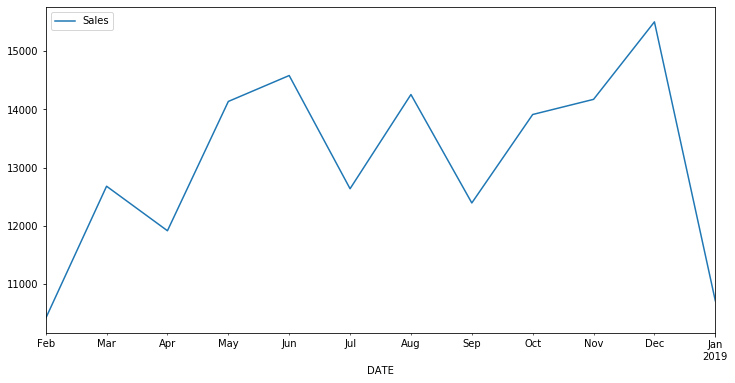

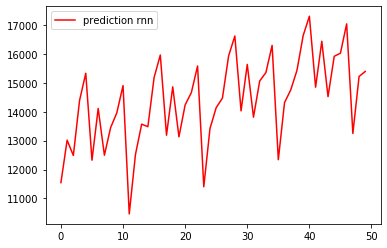

In [76]:
test['Sales'].plot(figsize=(12,6),legend=True)
true_pred.plot(legend=True,color='red')